In [409]:
# import necassary libraries
from sklearn.datasets import fetch_olivetti_faces
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt
import numpy as np
from sklearn.cluster import AgglomerativeClustering
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import DistanceMetric
from sklearn.model_selection import StratifiedShuffleSplit, cross_val_score
import scipy.cluster.hierarchy as sch


In [410]:
#load the olivetti faces dataset
X , y = fetch_olivetti_faces(return_X_y=True)

# Step 2: Apply PCA for dimensionality reduction
pca = PCA(n_components=50)  # Reduce to 50 dimensions
X = pca.fit_transform(X)

In [411]:
#split the data into training 70% , validation 15% and test 15%
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, stratify=y, random_state=81)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, stratify=y_temp, random_state=81)

In [412]:
print(f"Training set: {X_train.shape}, Validation set: {X_val.shape}, Test set: {X_test.shape}")

Training set: (280, 50), Validation set: (60, 50), Test set: (60, 50)


In [435]:
# Standardize the dataset (faces data are in [0, 1] range)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

In [436]:
# Initialize the SVM classifier
classifier = SVC(kernel='linear', random_state=81)

# Initialize Stratified K-Fold Cross-validation
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=81)

In [437]:
# List to store accuracy for each fold
accuracies = []

# Cross-validation loop
for train_index, val_index in skf.split(X_train_scaled, y_train):
    X_train_fold, X_val_fold = X_train_scaled[train_index], X_train_scaled[val_index]
    y_train_fold, y_val_fold = y_train[train_index], y_train[val_index]
    
    # Train the classifier on the current fold
    classifier.fit(X_train_fold, y_train_fold)
    
    # Predict on the validation fold
    y_pred = classifier.predict(X_val_fold)
    
    # Calculate accuracy
    accuracy = accuracy_score(y_val_fold, y_pred)
    accuracies.append(accuracy)

    print(f"Fold accuracy: {accuracy:.4f}")

Fold accuracy: 0.8750
Fold accuracy: 0.9464
Fold accuracy: 0.9464
Fold accuracy: 0.9643
Fold accuracy: 0.9286


In [438]:
# Average accuracy across the folds
average_accuracy = sum(accuracies) / len(accuracies)
print(f"Average accuracy across 5 folds: {average_accuracy:.4f}")

Average accuracy across 5 folds: 0.9321


In [439]:
# Train the final model on the full training data
classifier.fit(X_train_scaled, y_train)

# Predict on the validation set
y_val_pred = classifier.predict(X_val_scaled)

# Calculate accuracy on the validation set
validation_accuracy = accuracy_score(y_val, y_val_pred)
print(f"Validation set accuracy: {validation_accuracy:.4f}")

Validation set accuracy: 0.9500


In [440]:
# Predict on the test set
y_test_pred = classifier.predict(X_test_scaled)

# Calculate accuracy on the test set
test_accuracy = accuracy_score(y_test, y_test_pred)
print(f"Test set accuracy: {test_accuracy:.4f}")

Test set accuracy: 0.9833


In [441]:
# Step 4: Perform Hierarchical Clustering

# Define a function for Agglomerative Clustering
def hierarchical_clustering(X, n_clusters, metric='euclidean', linkage='average'):
    cluster = AgglomerativeClustering(n_clusters=n_clusters, metric=metric, linkage=linkage)
    return cluster.fit_predict(X)

In [442]:
# Function to calculate silhouette scores for different number of clusters
def silhouette_for_clusters(X, metric, linkage, cluster_range):
    silhouette_scores = []
    for n_clusters in cluster_range:
        labels = hierarchical_clustering(X, n_clusters=n_clusters, metric=metric, linkage=linkage)
        score = silhouette_score(X, labels, metric=metric if metric != 'precomputed' else 'euclidean')
        silhouette_scores.append(score)
    return silhouette_scores

In [443]:
# Euclidean Distance Clustering
cluster_range = range(2, 41)  # Range of clusters
sil_euclidean = silhouette_for_clusters(X_train_scaled, 'euclidean', 'average', cluster_range)

# Minkowski Distance Clustering (p=3 for generalization)
minkowski_dist = DistanceMetric.get_metric('minkowski', p=3)
minkowski_matrix_train = minkowski_dist.pairwise(X_train_scaled)
sil_minkowski = silhouette_for_clusters(minkowski_matrix_train, 'precomputed', 'average', cluster_range)

# Cosine Similarity Clustering
cos_sim = cosine_similarity(X_train_scaled)
sil_cosine = silhouette_for_clusters(cos_sim, 'precomputed', 'average', cluster_range)


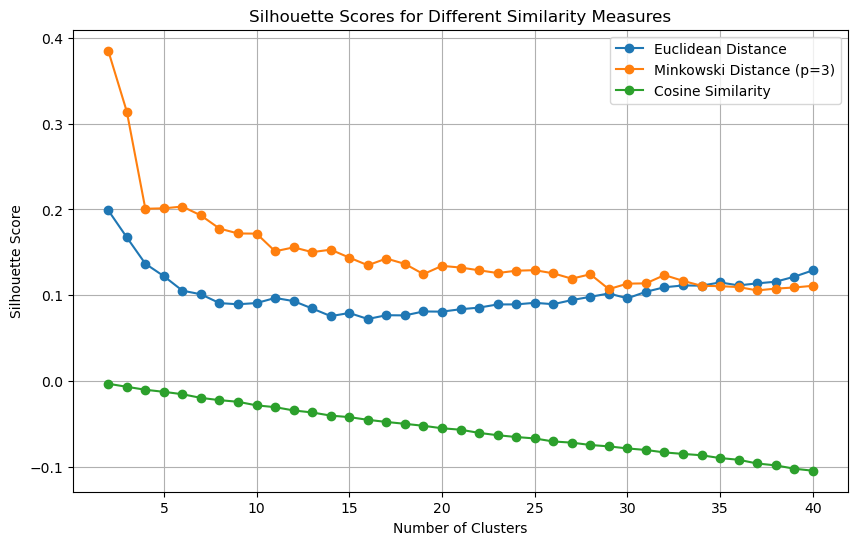

In [444]:
# Step 5: Plot Silhouette Scores for each measure
plt.figure(figsize=(10, 6))
plt.plot(cluster_range, sil_euclidean, label='Euclidean Distance', marker='o')
plt.plot(cluster_range, sil_minkowski, label='Minkowski Distance (p=3)', marker='o')
plt.plot(cluster_range, sil_cosine, label='Cosine Similarity', marker='o')
plt.title('Silhouette Scores for Different Similarity Measures')
plt.xlabel('Number of Clusters')
plt.ylabel('Silhouette Score')
plt.legend()
plt.grid(True)
plt.show()

In [445]:
def hierarchical_clustering_and_visualize(X, metric, n_clusters):
    # Perform Agglomerative Hierarchical Clustering
    model = AgglomerativeClustering(n_clusters=n_clusters, metric=metric, linkage='average')
    cluster_labels = model.fit_predict(X)
    
    # Dimensionality reduction using PCA for visualization
    pca = PCA(n_components=50)
    X_pca = pca.fit_transform(X)
    
    # Plotting the clusters
    plt.figure(figsize=(10, 6))
    plt.scatter(X_pca[:, 0], X_pca[:, 1], c=cluster_labels, cmap='rainbow', alpha=0.7)
    plt.title(f'Agglomerative Clustering with {metric} Distance')
    plt.xlabel('PCA Component 1')
    plt.ylabel('PCA Component 2')
    plt.colorbar()
    plt.show()
    
    return cluster_labels


In [446]:
# Step 6: Select the best euclidean clustering based on  silhouette score and train classifier
# Find the optimal number of clusters for euclidean distance
optimal_clusters_euclidean = cluster_range[np.argmax(sil_euclidean)]
print(f"Optimal number of clusters for euclidean distance: {optimal_clusters_euclidean}")

Optimal number of clusters for euclidean distance: 2


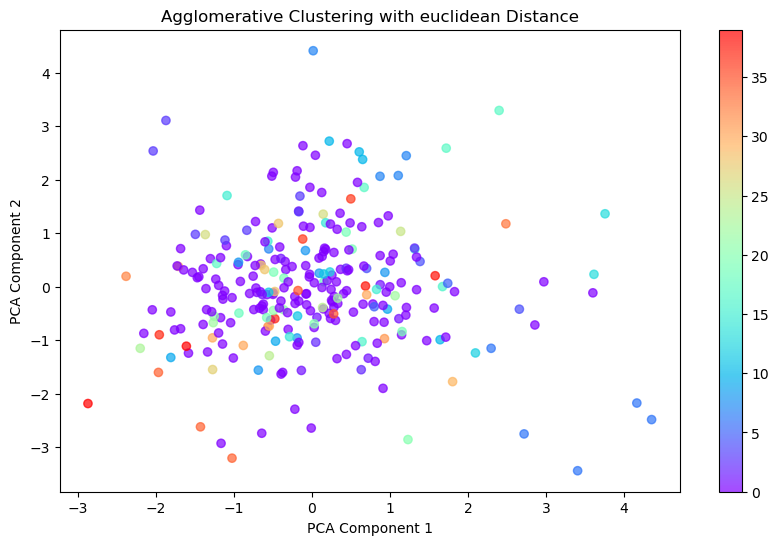

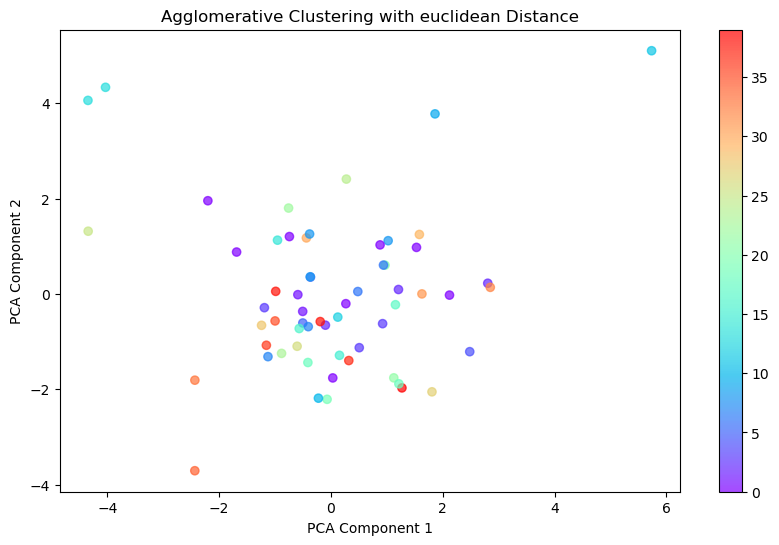

In [447]:
# Perform clustering using the euclidean distance with the optimal number of clusters and get labels for training data
y_train_cluster_labels = hierarchical_clustering_and_visualize(X_train_scaled, n_clusters=40, metric='euclidean')

# Perform clustering using the euclidean distance matrix with the optimal number of clusters and get labels for training data
y_val_fold = hierarchical_clustering_and_visualize(X_val_scaled, n_clusters=40, metric='euclidean')


In [448]:
# Step 4: One-hot encode the cluster labels (transform to feature matrix)
encoder = OneHotEncoder(sparse_output=False)
y_train_cluster_labels_encoded = encoder.fit_transform(y_train_cluster_labels.reshape(-1, 1))
y_val_cluster_labels_encoded = encoder.fit_transform(y_val_fold.reshape(-1, 1))

In [449]:
# Step 5: Combine original features with the cluster labels as new features
X_train_new = np.hstack((X_train_scaled, y_train_cluster_labels_encoded))
X_val_new = np.hstack((X_val_scaled, y_val_cluster_labels_encoded))

In [450]:
# Train a classifier on the clustered data
clf_final = SVC(kernel='linear', random_state=81)

# Perform k-fold cross-validation on the original data with Minkowski-based labels
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=81)
# List to store accuracy for each fold
accuracies = []

# Cross-validation loop
for train_index, val_index in skf.split(X_train_new, y_train):
    X_train_fold, X_val_fold = X_train_new[train_index], X_train_new[val_index]
    y_train_fold, y_val_fold = y_train[train_index], y_train[val_index]
    
    # Train the classifier on the current fold
    classifier.fit(X_train_fold, y_train_fold)
    
    # Predict on the validation fold
    y_pred = classifier.predict(X_val_fold)
    
    # Calculate accuracy
    accuracy = accuracy_score(y_val_fold, y_pred)
    accuracies.append(accuracy)

    print(f"Fold accuracy: {accuracy:.4f}")

# Average accuracy across the folds
average_accuracy = sum(accuracies) / len(accuracies)
print(f"Average accuracy across 5 folds: {average_accuracy:.4f}")



Fold accuracy: 0.8929
Fold accuracy: 0.9464
Fold accuracy: 0.9464
Fold accuracy: 0.9643
Fold accuracy: 0.9286
Average accuracy across 5 folds: 0.9357


In [451]:
# Fit the final classifier on the full training set
clf_final.fit(X_train_new, y_train)

SVC(kernel='linear', random_state=81)

In [452]:
# Predict on the validation set
y_val_pred = clf_final.predict(X_val_new)

# Calculate accuracy on the validation set
validation_accuracy = accuracy_score(y_val, y_val_pred)
print(f"Validation set accuracy: {validation_accuracy:.4f}")

Validation set accuracy: 0.9500


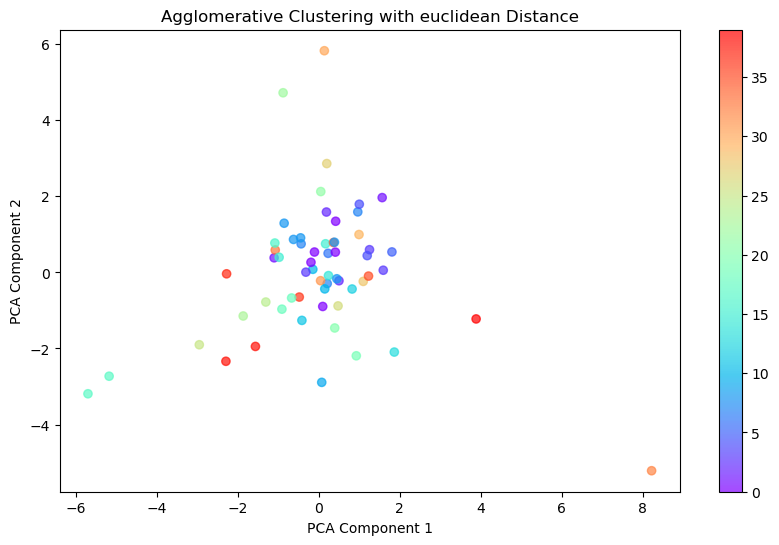

In [453]:
# Perform clustering using the euclidean distance with the optimal number of clusters and get labels for test data
y_test_cluster_labels = hierarchical_clustering_and_visualize(X_test_scaled, n_clusters=40, metric='euclidean')

In [454]:
#  One-hot encode the cluster labels (transform to feature matrix)
encoder = OneHotEncoder(sparse_output=False)
y_test_cluster_labels_encoded = encoder.fit_transform(y_test_cluster_labels.reshape(-1, 1))

In [455]:
#Combine original features with the cluster labels as new features
X_test_new = np.hstack((X_test_scaled, y_test_cluster_labels_encoded))

In [456]:
y_test_pred = clf_final.predict(X_test_new)

# Calculate accuracy on the test set
test_accuracy = accuracy_score(y_test, y_test_pred)
print(f"Test set accuracy: {test_accuracy:.4f}")


Test set accuracy: 0.9833


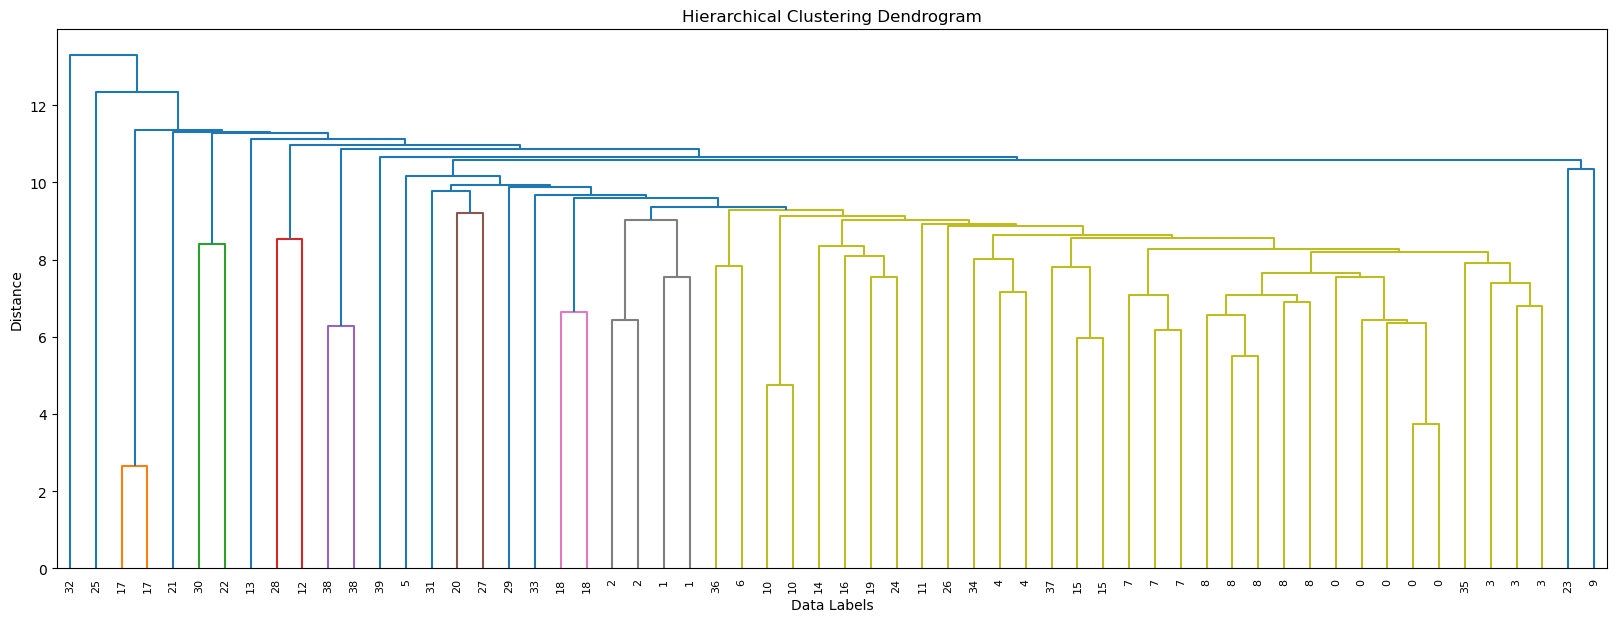

In [468]:
# Plot the dendrogram for test data using euclidean
plt.figure(figsize=(20, 7))
plt.title('Hierarchical Clustering Dendrogram')
plt.xlabel('Data Labels')
plt.ylabel('Distance')
dendro = sch.dendrogram(sch.linkage(X_test_scaled,"average", metric="euclidean"),
                        labels=y_test_cluster_labels,
                        leaf_rotation=90,
                        leaf_font_size=8,
                        show_contracted=True)
plt.show()



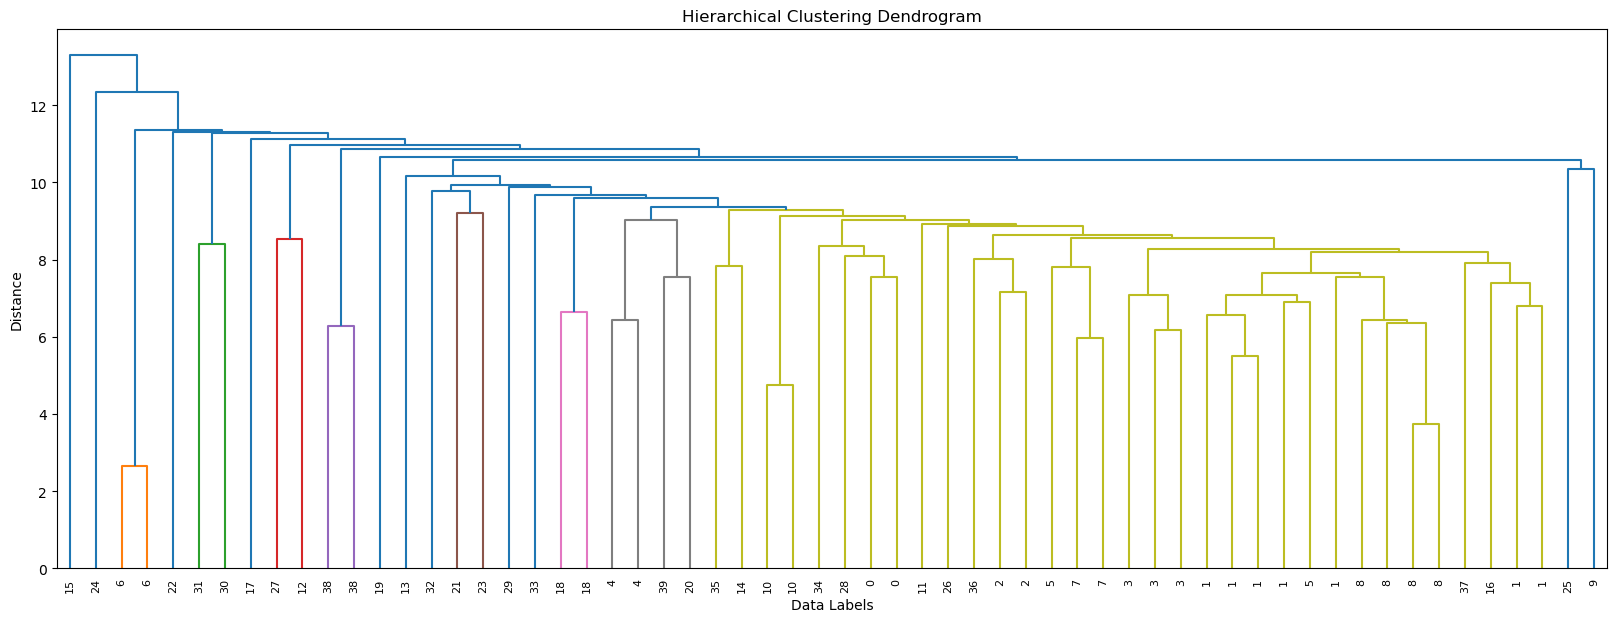

In [473]:
# Minkowski Distance Clustering (p=3 for generalization)
minkowski_dist = DistanceMetric.get_metric('minkowski', p=3)
minkowski_matrix_train = minkowski_dist.pairwise(X_test_scaled)

y_test_cluster_labels = hierarchical_clustering(minkowski_matrix_train, 40 , 'precomputed', 'average')

# Plot the dendrogram for test data using 
plt.figure(figsize=(20, 7))
plt.title('Hierarchical Clustering Dendrogram')
plt.xlabel('Data Labels')
plt.ylabel('Distance')
dendro = sch.dendrogram(sch.linkage(X_test_scaled,"average", metric="minkowski"),
                        labels=y_test_cluster_labels,
                        leaf_rotation=90,
                        leaf_font_size=8,
                        show_contracted=True)
plt.show()



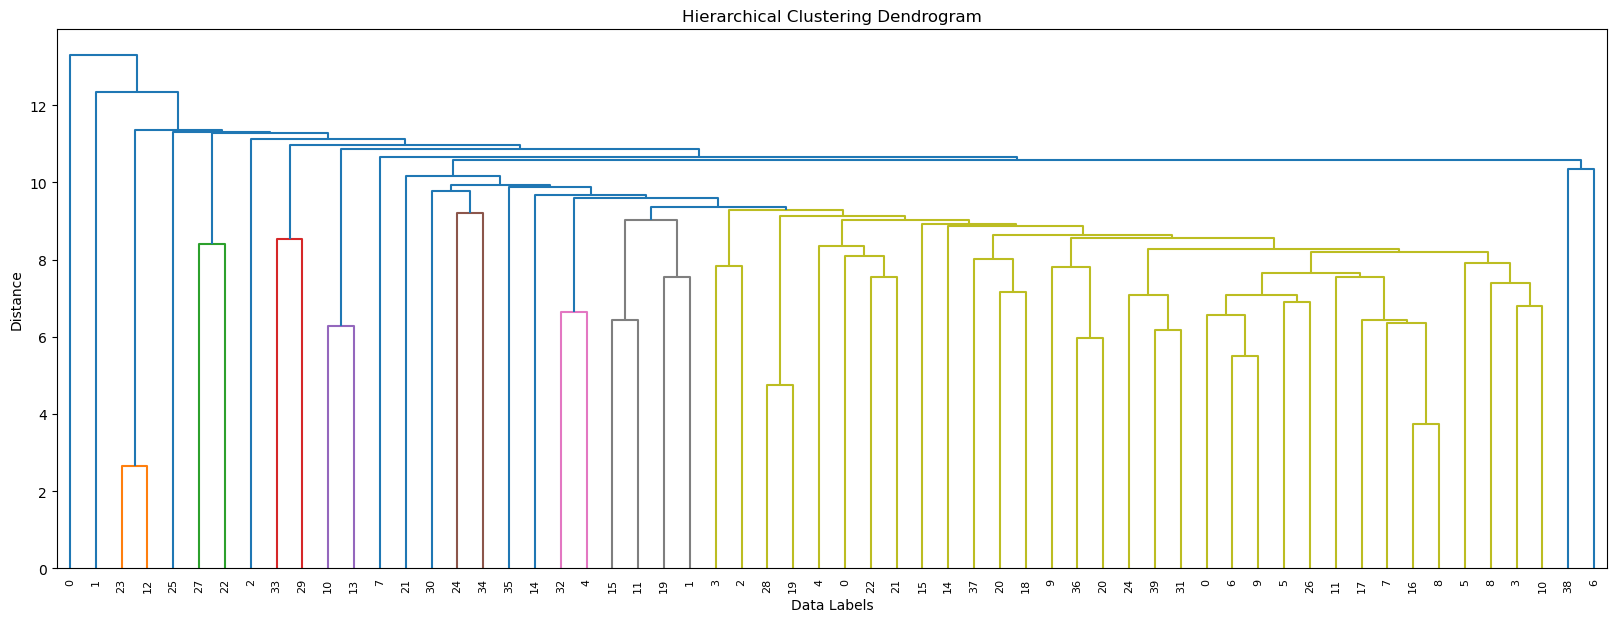

In [478]:
# Cosine Similarity Clustering
cos_sim = cosine_similarity(X_test_scaled)

y_test_cluster_labels = hierarchical_clustering(cos_sim, 40 , 'precomputed', 'average')

# Plot the dendrogram for test data using 
plt.figure(figsize=(20, 7))
plt.title('Hierarchical Clustering Dendrogram')
plt.xlabel('Data Labels')
plt.ylabel('Distance')
dendro = sch.dendrogram(sch.linkage(X_test_scaled,"average", metric="minkowski"),
                        labels=y_test_cluster_labels,
                        leaf_rotation=90,
                        leaf_font_size=8,
                        show_contracted=True)
plt.show()

